In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
colourmap = plt.get_cmap('tab10')

In [9]:
import requests
import pandas as pd
from pandas.api.types import CategoricalDtype

# TODO

use the src.util module/package instead of raw coded here

In [32]:
nrows = 100

url = 'https://opendatakingston.cityofkingston.ca/api/records/1.0/search/' + \
    '?dataset=household-travel-survey-trips&q=&rows=' + str(nrows)

response = requests.get(url)
records = response.json()['records']

df = pd.DataFrame()
for ix, record in enumerate(records):
    df = pd.concat([df, 
                    pd.DataFrame(record['fields'], index=[ix])],
                    )

### Investigation of structure, quality and content
Overall, the EDA approach is very iterative. At the end of your investigation you might discover something that will require you to redo everything once more. That is normal! But to impose at least a little bit of structure, I propose the following structure for your investigations:

1. Structure investigation: Exploring the general shape of the dataset, as well as the data types of your features.
1. Quality investigation: Get a feeling for the general quality of the dataset, with regards to duplicates, missing values and unwanted entries.
1. Content investigation: Once the structure and quality of the dataset is understood, we can go ahead and perform a more in-depth exploration on the features values and look at how different features relate to each other.

## 1. Structure Investigation

Let's look at the general structure of the data set.
Keep in mind that we currently only have a limited subset of the data as set above in `nrows`.

In [16]:
# show the size of the dataset
print(df.shape)

# count the data types present
print(pd.value_counts(df.dtypes))

(100, 63)
object     39
float64    13
int64      11
dtype: int64


### 1.1 Structure of numerical features

Data types can be numerical or non-numerical. First, let's look at the **numerical** entries.

In [25]:
df.describe(include='number').iloc[:,:10]

,personid,originada,walkinggoogledistance,drivinggoogledistance,workerflag,householdid,homecsd,destada,bikinggoogledistance,bikinggoogleduration
count,1.000000e+02,1.000000e+02,35.000000,100.000000,55.0,100.00000,100.0,1.000000e+02,55.000000,55.000000
mean,7.178595e+06,3.237211e+07,2048.400000,9057.990000,1.0,71785.93000,3510010.0,3.271311e+07,3157.672727,664.581818
std,9.008498e+04,9.297736e+06,1089.995553,41751.895466,0.0,900.84912,0.0,8.744376e+06,1692.978791,339.069625
min,7.007501e+06,9.999990e+05,78.000000,78.000000,1.0,70075.00000,3510010.0,9.999990e+05,78.000000,37.000000
25%,7.112426e+06,3.510001e+07,1177.500000,1468.000000,1.0,71124.25000,3510010.0,3.510001e+07,1444.500000,356.000000
50%,7.189551e+06,3.510001e+07,1476.000000,3966.000000,1.0,71895.50000,3510010.0,3.510001e+07,3559.000000,709.000000
75%,7.243052e+06,3.510001e+07,2933.500000,6509.500000,1.0,72430.50000,3510010.0,3.510001e+07,4452.000000,938.000000
max,7.335003e+06,3.511000e+07,3864.000000,419621.000000,1.0,73350.00000,3510010.0,3.511000e+07,6058.000000,1184.000000


In [26]:
df.describe(include='number').iloc[:,10:20]

,googledistance,distanceeuclid,googleduration,numvehocc,destsubarea,walkinggoogleduration,tripnum,drivinggoogleduration,homeada,tripid
count,96.000000,100.000000,96.000000,71.000000,100.000000,35.000000,100.00,100.000000,1.000000e+02,1.000000e+02
mean,9168.479167,7492.743507,750.583333,1.690141,175.200000,1529.228571,2.79,636.960000,3.510001e+07,7.178595e+08
std,42611.432769,38568.318904,1523.263793,0.950061,128.577925,812.500320,2.10,1490.028004,4.464665e+00,9.008498e+06
min,78.000000,48.093659,30.000000,1.000000,100.000000,55.000000,1.00,30.000000,3.510000e+07,7.007501e+08
25%,1450.000000,1151.018549,343.250000,1.000000,100.000000,875.500000,1.00,215.500000,3.510001e+07,7.112426e+08
50%,3991.500000,2729.842900,592.000000,1.000000,100.000000,1127.000000,2.00,488.000000,3.510001e+07,7.189551e+08
75%,6190.000000,5056.866322,759.500000,2.000000,200.000000,2148.000000,4.00,674.750000,3.510002e+07,7.243052e+08
max,419621.000000,387575.958100,15068.000000,5.000000,910.000000,2935.000000,10.00,15068.000000,3.510002e+07,7.335003e+08


In [27]:
df.describe(include='number').iloc[:,20:]

,tripfactorrounded,studentflag,lasttrip,busboardings
count,100.00000,19.0,30.0,4.0
mean,21.04300,1.0,1.0,1.0
std,16.12047,0.0,0.0,0.0
min,4.00000,1.0,1.0,1.0
25%,7.50000,1.0,1.0,1.0
50%,14.95000,1.0,1.0,1.0
75%,36.30000,1.0,1.0,1.0
max,53.70000,1.0,1.0,1.0


Numerical datatypes can be ordinal and/or categorical; `ordinal` implying that there is a meaningful relationship between two numbers. For example, the comparing the values of `personid` from two separate records has no real use in analysis. These types of attributes can be better thought of as `categorical`.
Other numerical attributes are being used as `flags`, where a `1` is coded for `True`, while a `0` is coded for `False`. They can stay as numerical for now.

#### convert columns to a categorical datatype

In [34]:
raw_df = df.copy()

columns_to_cat = ['personid', 'originada', 'householdid', 'homecsd', 'destada', 'homeada', 'tripid']
for col in columns_to_cat:
    df[col] = df[col].astype('category')

<AxesSubplot:title={'center':'Unique values per feature'}>

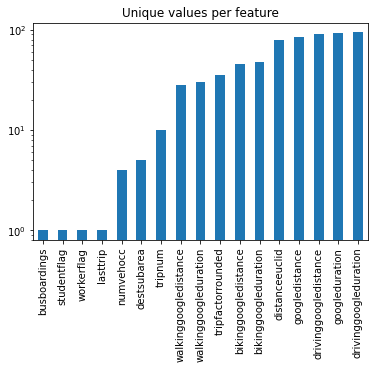

In [31]:
# For each remaining numerical feature, compute the number of unique entries
unique_values = df.select_dtypes(include='number').nunique().sort_values()

# Plot this information with y-axis in log-scale
unique_values.plot.bar(logy=True, title='Unique values per feature');

### 1.2 Structure of non-numerical features

Now let's look at the non-numerical features, including the numerical that we converted into categorical.

In [38]:
df.describe(exclude='number').iloc[:,:10]

,modesummary,personid,originada,modesummarytext,primarymode,occstatus,transitpass,hhincome,mode1,haveveh
count,100,100,100,100,100,100,100,100,100,100
unique,13,64,15,13,8,7,3,6,7,2
top,-1-777-777-777-777-,7078102,35100009,-Driver-----,Auto driver,Work Full-Time,No,"$125,000 or more",Auto driver,Yes
freq,47,5,13,47,52,48,67,31,49,93


In [39]:
df.describe(exclude='number').iloc[:,10:20]

,householdid,agerange,destfsa,homecsd,destada,originfocusarea,traveldayofwk,walkable,homefsa,gendermf
count,100,100,100,100,100,100,100,81,100,100
unique,39,14,6,1,14,16,5,2,4,2
top,72587,55 to 59,K7M,3510010,35100011,A,Friday,"Not Walkable (for this motorized trip, walking...",K7M,Male
freq,6,18,32,100,17,13,34,63,34,54


In [40]:
df.describe(exclude='number').iloc[:,20:30]

,hbgroupdesc,destfocusarea,destreportzone,originsubarea,bikeable,origin,originfsa,hbdetaileddesc,originreportzone,homesubarea
count,100,100,100,100,81,100,100,100,100,100
unique,4,16,16,6,2,6,6,7,16,4
top,HBO,A,"Cataraqui North, Westbrook Enclave",Central,Bikeable (motorized trip if biked via most lik...,Home,K7M,HBRecSoc,"Cataraqui North, Westbrook Enclave",Central
freq,55,12,12,48,42,43,29,22,13,49


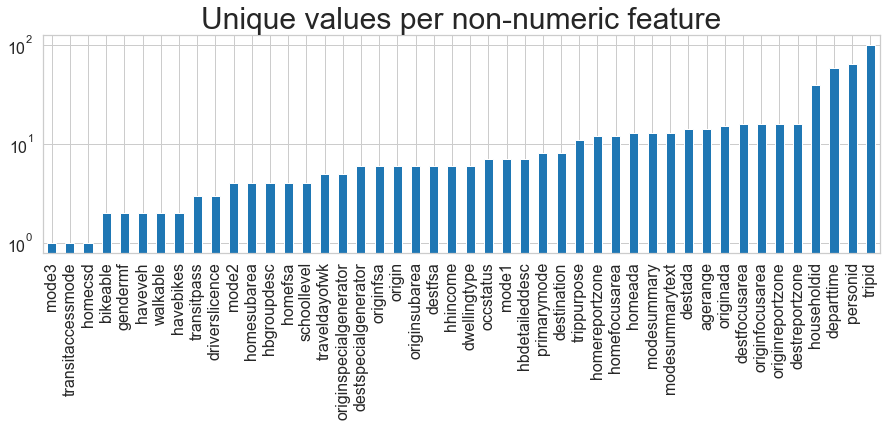

In [43]:
# For each numerical feature compute number of unique entries
unique_values = df.select_dtypes(exclude="number").nunique().sort_values()

# Plot information with y-axis in log-scale
ax1 = unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per non-numeric feature", fontsize=16, color=colourmap(0))
ax1.title.set_size(30)

## 2. Quality Investigation

Before focusing on the content of the information, let's first take a look at the general quality of the dataset. The goal is to have a global view of the dataset with regards to things lik *duplicates*, *missing values* and *unwanted entries* or *recording errors*.

### 2.1 Duplicates

Duplicates are entries that represent the same sample point multiple times. For example, if a measurement was registered twice by two different people.

In [46]:
ignore_col = 'tripid'
n_duplicates = df.drop(labels=['tripid'], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in the dataset, after ignoring {ignore_col}.")

You seem to have 0 duplicates in the dataset, after ignoring tripid.


In [47]:
ignore_col = 'personid'
n_duplicates = df.drop(labels=['tripid'], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in the dataset, after ignoring {ignore_col}.")

You seem to have 0 duplicates in the dataset, after ignoring personid.


In [48]:
ignore_col = 'householdid'
n_duplicates = df.drop(labels=['tripid'], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in the dataset, after ignoring {ignore_col}.")

You seem to have 0 duplicates in the dataset, after ignoring householdid.


### 2.2 Missing Values

Another quality issue worth investigating are **missing values**. Having some missing values is normal; for this dataset specifically, not all trips will make use of 2 or more modes of travel (mode2, mode3) and a missing value is expected here.

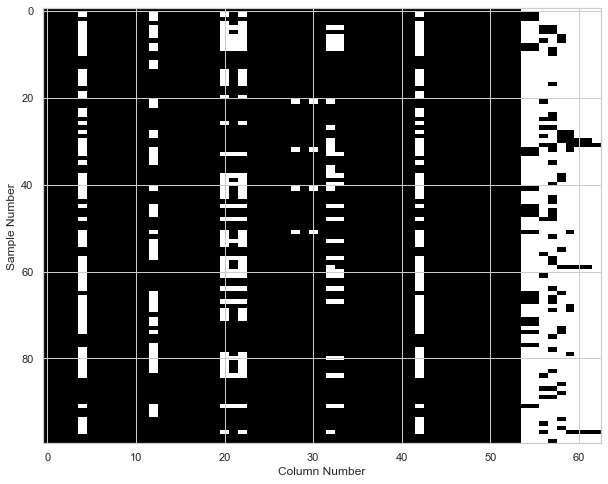

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

In [50]:
for count, name in enumerate(df.columns):
    print(count, name)

0 modesummary
1 personid
2 originada
3 modesummarytext
4 walkinggoogledistance
5 primarymode
6 drivinggoogledistance
7 occstatus
8 transitpass
9 hhincome
10 mode1
11 haveveh
12 workerflag
13 householdid
14 agerange
15 destfsa
16 homecsd
17 destada
18 originfocusarea
19 traveldayofwk
20 bikinggoogledistance
21 walkable
22 bikinggoogleduration
23 homefsa
24 gendermf
25 hbgroupdesc
26 destfocusarea
27 destreportzone
28 googledistance
29 distanceeuclid
30 googleduration
31 originsubarea
32 numvehocc
33 bikeable
34 origin
35 originfsa
36 hbdetaileddesc
37 originreportzone
38 homesubarea
39 destsubarea
40 trippurpose
41 driverslicence
42 walkinggoogleduration
43 homefocusarea
44 destination
45 tripnum
46 homereportzone
47 havebikes
48 departtime
49 drivinggoogleduration
50 homeada
51 dwellingtype
52 tripid
53 tripfactorrounded
54 schoollevel
55 studentflag
56 originspecialgenerator
57 lasttrip
58 destspecialgenerator
59 mode2
60 transitaccessmode
61 busboardings
62 mode3
